# Chargement du dataset

On charge les librairies nécéssaires 

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import xgboost as xgb
from sklearn.metrics import mean_absolute_percentage_error



On charge le dataset

In [65]:
X = pd.read_csv('../X_train_J01Z4CN.csv')
y = pd.read_csv('../y_train_OXxrJt1.csv')

# On n'a pas besoin de l'ID
X = X.drop('id_annonce', axis=1)
y= y.drop('id_annonce', axis=1)

X.shape

(37368, 26)

Étude des features du dataset

In [66]:
def features_incomplete(X):   
    Features_incomplete = []
    for x in X.columns:
        print(x, (X[x].isnull().sum()/len(X[x])*100, X[x].dtype))
        if X[x].isnull().sum()/len(X[x])*100 > 48:
            Features_incomplete.append(x)
    return Features_incomplete

features_incomplete(X)



property_type (0.0, dtype('O'))
approximate_latitude (0.0, dtype('float64'))
approximate_longitude (0.0, dtype('float64'))
city (0.0, dtype('O'))
postal_code (0.0, dtype('int64'))
size (1.3701562834510812, dtype('float64'))
floor (73.92688931706273, dtype('float64'))
land_size (58.30389638193106, dtype('float64'))
energy_performance_value (48.97238278741169, dtype('float64'))
energy_performance_category (48.97238278741169, dtype('O'))
ghg_value (50.41211731963177, dtype('float64'))
ghg_category (50.41211731963177, dtype('O'))
exposition (75.66366944979663, dtype('O'))
nb_rooms (4.190751445086705, dtype('float64'))
nb_bedrooms (7.3137443802183695, dtype('float64'))
nb_bathrooms (35.519695996574605, dtype('float64'))
nb_parking_places (0.0, dtype('float64'))
nb_boxes (0.0, dtype('float64'))
nb_photos (0.0, dtype('float64'))
has_a_balcony (0.0, dtype('float64'))
nb_terraces (0.0, dtype('float64'))
has_a_cellar (0.0, dtype('float64'))
has_a_garage (0.0, dtype('float64'))
has_air_conditioni

['floor',
 'land_size',
 'energy_performance_value',
 'energy_performance_category',
 'ghg_value',
 'ghg_category',
 'exposition']

## Étude des features avec plus de 48 % de valeurs manquantes

In [67]:
print(Features_incomplete)
for x in Features_incomplete:
    # On regarde le nombre de valeurs uniques pour les features catégorielles et le min et max pour les features numériques
    if X[x].dtype == 'object':
        print(x, X[x].nunique())
    else:
        print(x, X[x].min(), X[x].max())
            

['floor', 'land_size', 'energy_performance_value', 'energy_performance_category', 'ghg_value', 'ghg_category', 'exposition']
floor 1.0 55.0
land_size 1.0 6203700.0
energy_performance_value 0.0 100000.0
energy_performance_category 7
ghg_value 0.0 17024.0
ghg_category 7
exposition 12


ghg_category et energy_performance_category correspondent à la même information que ghg_value et energy_performance_value mais en moins précis donc on les enlève  

In [68]:
X.drop(columns=['ghg_category', 'energy_performance_category'], inplace=True)

Pour floor et land_size on peut penser que les valeurs manquantes correspondent à des maisons pour floor et à des appartements pour land_size donc on les remplace par 0

In [69]:
X['floor'].fillna(0, inplace=True)
X['land_size'].fillna(0, inplace=True)

Exposition a trop de données manquantes donc on l'enlève

In [70]:
X.drop(columns=['exposition'], inplace=True)

État des lieux des features incomplètes 

In [71]:
features_incomplete(X)

property_type (0.0, dtype('O'))
approximate_latitude (0.0, dtype('float64'))
approximate_longitude (0.0, dtype('float64'))
city (0.0, dtype('O'))
postal_code (0.0, dtype('int64'))
size (1.3701562834510812, dtype('float64'))
floor (0.0, dtype('float64'))
land_size (0.0, dtype('float64'))
energy_performance_value (48.97238278741169, dtype('float64'))
ghg_value (50.41211731963177, dtype('float64'))
nb_rooms (4.190751445086705, dtype('float64'))
nb_bedrooms (7.3137443802183695, dtype('float64'))
nb_bathrooms (35.519695996574605, dtype('float64'))
nb_parking_places (0.0, dtype('float64'))
nb_boxes (0.0, dtype('float64'))
nb_photos (0.0, dtype('float64'))
has_a_balcony (0.0, dtype('float64'))
nb_terraces (0.0, dtype('float64'))
has_a_cellar (0.0, dtype('float64'))
has_a_garage (0.0, dtype('float64'))
has_air_conditioning (0.0, dtype('float64'))
last_floor (0.0, dtype('float64'))
upper_floors (0.0, dtype('float64'))


['energy_performance_value', 'ghg_value']

## Remplir les features incomplètes restantes 

In [72]:
def features_incomplete(X):   
    Features_incomplete = []
    for x in X.columns:
        if X[x].isnull().sum()/len(X[x])*100 > 0:
            Features_incomplete.append(x)
    return Features_incomplete

for x in features_incomplete(X):
    # On remplit les valeurs manquantes par la valeur la plus fréquente
    X[x].fillna(X[x].value_counts().index[0], inplace=True)


In [73]:
X.describe()
for x in X.columns:
    print(X[x].isnull().sum())

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


Il reste à s'occuper des variables catégorielles : city et property_type

In [74]:
# One hot encoding pour property type
X = pd.get_dummies(X, columns=['property_type'], drop_first=True)


In [75]:
X.describe()

,approximate_latitude,approximate_longitude,postal_code,size,floor,land_size,energy_performance_value,ghg_value,nb_rooms,nb_bedrooms,...,property_type_maison,property_type_manoir,property_type_moulin,property_type_parking,property_type_propriété,property_type_péniche,property_type_terrain,property_type_terrain à bâtir,property_type_viager,property_type_villa
count,37368.000000,37368.000000,37368.000000,37368.000000,37368.000000,3.736800e+04,37368.000000,37368.00000,37368.000000,37368.000000,...,37368.000000,37368.000000,37368.000000,37368.000000,37368.000000,37368.000000,37368.000000,37368.000000,37368.000000,37368.000000
mean,46.546155,2.619087,53598.371655,1075.283076,0.907220,1.666037e+03,131.737958,18.81626,4.235121,2.874759,...,0.419477,0.000401,0.000455,0.002569,0.010918,0.000214,0.041051,0.007975,0.004737,0.020900
std,2.356581,2.597060,28807.220527,5518.327701,3.758532,3.519228e+04,569.659133,219.08209,2.924919,2.076454,...,0.493480,0.020032,0.021325,0.050621,0.103921,0.014630,0.198411,0.088946,0.068661,0.143052
min,41.374436,-4.733545,1000.000000,1.000000,0.000000,0.000000e+00,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,43.921547,1.096014,30150.000000,74.000000,0.000000,0.000000e+00,55.000000,6.00000,3.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,46.939440,2.380793,59000.000000,114.000000,0.000000,0.000000e+00,55.000000,6.00000,4.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,48.841511,4.624248,78210.000000,230.000000,1.000000,5.950000e+02,182.000000,16.00000,5.000000,4.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,51.075892,9.503198,95880.000000,411311.000000,55.000000,6.203700e+06,100000.000000,17024.00000,130.000000,118.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


One hot encoding pour city serait trop lourd donc on va utiliser un label encoder

In [76]:
# Label encoder pour la feature city
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
X['city'] = le.fit_transform(X['city'])


In [77]:
X.describe()

,approximate_latitude,approximate_longitude,city,postal_code,size,floor,land_size,energy_performance_value,ghg_value,nb_rooms,...,property_type_maison,property_type_manoir,property_type_moulin,property_type_parking,property_type_propriété,property_type_péniche,property_type_terrain,property_type_terrain à bâtir,property_type_viager,property_type_villa
count,37368.000000,37368.000000,37368.000000,37368.000000,37368.000000,37368.000000,3.736800e+04,37368.000000,37368.00000,37368.000000,...,37368.000000,37368.000000,37368.000000,37368.000000,37368.000000,37368.000000,37368.000000,37368.000000,37368.000000,37368.000000
mean,46.546155,2.619087,4313.454881,53598.371655,1075.283076,0.907220,1.666037e+03,131.737958,18.81626,4.235121,...,0.419477,0.000401,0.000455,0.002569,0.010918,0.000214,0.041051,0.007975,0.004737,0.020900
std,2.356581,2.597060,2478.413580,28807.220527,5518.327701,3.758532,3.519228e+04,569.659133,219.08209,2.924919,...,0.493480,0.020032,0.021325,0.050621,0.103921,0.014630,0.198411,0.088946,0.068661,0.143052
min,41.374436,-4.733545,0.000000,1000.000000,1.000000,0.000000,0.000000e+00,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,43.921547,1.096014,2021.750000,30150.000000,74.000000,0.000000,0.000000e+00,55.000000,6.00000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,46.939440,2.380793,4616.000000,59000.000000,114.000000,0.000000,0.000000e+00,55.000000,6.00000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,48.841511,4.624248,6211.000000,78210.000000,230.000000,1.000000,5.950000e+02,182.000000,16.00000,5.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,51.075892,9.503198,8642.000000,95880.000000,411311.000000,55.000000,6.203700e+06,100000.000000,17024.00000,130.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Étude de y 

/var/folders/zp/04t34kkj27ldhv8wcvlpqz300000gn/T/ipykernel_78730/4144177605.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y, kde=False, fit=stats.johnsonsu)
/var/folders/zp/04t34kkj27ldhv8wcvlpqz300000gn/T/ipykernel_78730/4144177605.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y, kd

<AxesSubplot: title={'center': 'Normal'}>

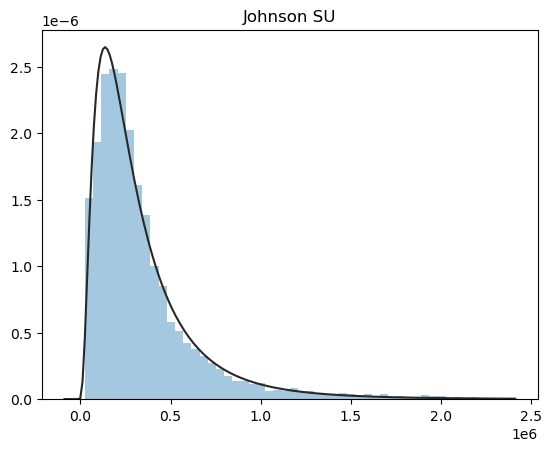

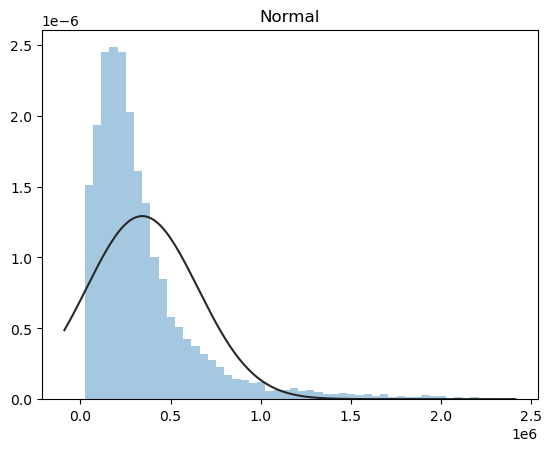

In [78]:
import scipy.stats as stats
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=stats.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=stats.norm)

In [79]:
y = np.log1p(y)
y = y.reset_index(drop=True)

/var/folders/zp/04t34kkj27ldhv8wcvlpqz300000gn/T/ipykernel_78730/4144177605.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y, kde=False, fit=stats.johnsonsu)
/var/folders/zp/04t34kkj27ldhv8wcvlpqz300000gn/T/ipykernel_78730/4144177605.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y, kd

<AxesSubplot: title={'center': 'Normal'}>

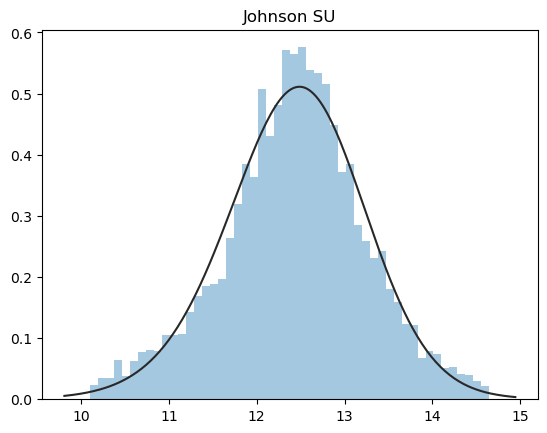

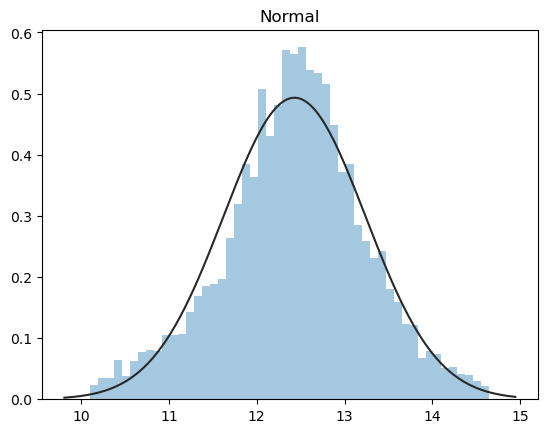

In [80]:
import scipy.stats as stats
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=stats.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=stats.norm)

# On peut normaliser nos features

In [81]:
# Normalisation de features numériques
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
for x in X.columns:
    if X[x].dtype != 'object':
        X[x] = scaler.fit_transform(X[x].values.reshape(-1,1))
        

In [82]:
X.describe()

,approximate_latitude,approximate_longitude,city,postal_code,size,floor,land_size,energy_performance_value,ghg_value,nb_rooms,...,property_type_maison,property_type_manoir,property_type_moulin,property_type_parking,property_type_propriété,property_type_péniche,property_type_terrain,property_type_terrain à bâtir,property_type_viager,property_type_villa
count,37368.000000,37368.000000,37368.000000,37368.000000,37368.000000,37368.000000,37368.000000,37368.000000,37368.000000,37368.000000,...,37368.000000,37368.000000,37368.000000,37368.000000,37368.000000,37368.000000,37368.000000,37368.000000,37368.000000,37368.000000
mean,0.533087,0.516455,0.499127,0.554367,0.002612,0.016495,0.000269,0.001317,0.001105,0.032578,...,0.419477,0.000401,0.000455,0.002569,0.010918,0.000214,0.041051,0.007975,0.004737,0.020900
std,0.242910,0.182420,0.286787,0.303617,0.013416,0.068337,0.005673,0.005697,0.012869,0.022499,...,0.493480,0.020032,0.021325,0.050621,0.103921,0.014630,0.198411,0.088946,0.068661,0.143052
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.262549,0.409473,0.233945,0.307230,0.000177,0.000000,0.000000,0.000550,0.000352,0.023077,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.573626,0.499717,0.534136,0.611298,0.000275,0.000000,0.000000,0.000550,0.000352,0.030769,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.769686,0.657299,0.718699,0.813765,0.000557,0.018182,0.000096,0.001820,0.000940,0.038462,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Visualisation des scores importances

/opt/anaconda3/envs/TP1/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<AxesSubplot: >

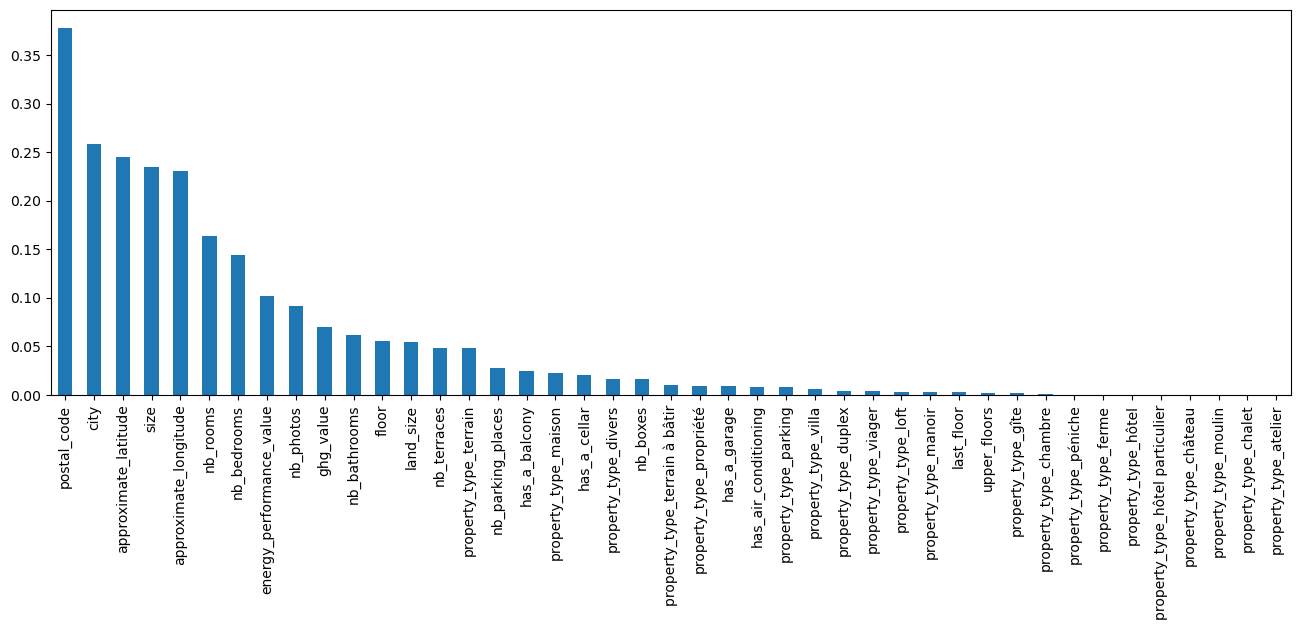

In [83]:
# Importance des features avec mi_score
from sklearn.feature_selection import mutual_info_regression
mi = mutual_info_regression(X, y)
mi = pd.Series(mi)
mi.index = X.columns
mi.sort_values(ascending=False)

#Plot
mi.sort_values(ascending=False).plot.bar(figsize=(16,5))
    

## Clustering

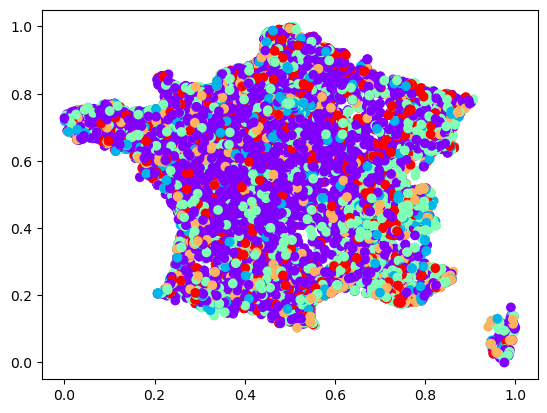

In [88]:
### Kmeans

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=0).fit(X)
X['cluster'] = kmeans.labels_

# On visualise les clusters par latitude et longitude
plt.scatter(X['approximate_longitude'], X['approximate_latitude'], c=X['cluster'], cmap='rainbow')


# Test XBBoost

In [93]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2)

my_kfold = KFold(n_splits = 5,shuffle = True)
features_improv = {"n_estimators" :[x for x in range(100,800,100)]}

xgbc = GridSearchCV(xgb.XGBRegressor(),param_grid=features_improv,cv=my_kfold,n_jobs=-1)
xgbc.fit(train_X,train_y)
print(xgbc.best_params_)

prediction = xgbc.predict(test_X)

{'n_estimators': 600}


In [100]:
print(prediction[:10])

[13.342668 14.320288 11.607715 13.325257 12.79712  13.734584 12.158088
 11.872116 11.081156 10.928784]


In [104]:
mean_absolute_percentage_error(np.expm1(test_y), np.expm1(prediction))*100

28.604761992387097